In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import transpose
from numpy.linalg import inv
plt.style.use('ggplot')
np.random.seed(0)
from numpy import genfromtxt

In [2]:
#reading in data
zipcombo = np.array(genfromtxt('zipcombo.dat.txt'))     #full data set

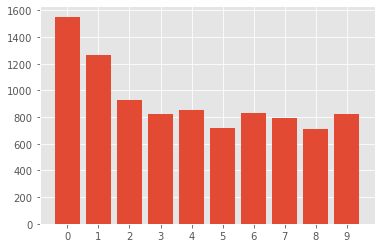

In [3]:
vals, freq = np.unique(zipcombo[:,0], return_counts=True)
plt.bar(vals, freq)
plt.xticks(np.arange(0, 10, 1))
plt.savefig('Q1_1.png')
plt.show()

In [4]:

def OneVersusRest(data, classes):
    """ function to transform data labels into -1,1 where 1 is class k and -1 is rest 
    input: original labels
    output: transformed labels in rows=NumberOfDataPoints by columns=NumberOfClasses dimensional array so that each column k has labels +1 if th original label was k or -1 else"""
    original_labels = data[:,[0]]
    NumberOfDataPoints = data.shape[0]
    NumberOfClasses = classes.shape[1]
    transformed_labels = np.zeros((NumberOfDataPoints, NumberOfClasses))

    for i in range(NumberOfClasses):
        k = classes[0,i]
        transformed_labels[:,i] = 2*(original_labels[:,0]==k) - 1
    return transformed_labels

def Poly_kernel_matrix(x,y,d):
    """ function to compute gram matrix for polynomial kernel with power d=1. Using the first power we can then iteratively multiply the gram matrix with itself to build higher powers of it. """
    data1 = x.copy()
    data2 = y.copy()
    data1 = data1[:,1:] #getting rid of label column
    data2 = data2[:,1:] #getting rid of label column
    K = (data1@ np.transpose(data2))
    return K



def test_one_versus_rest(testlabels,classes,powers, alpha, kernelmatrix):
    """ testing function for one versus rest with polynomial kernel
    inputs:
        testlabels: the ground truth labels of the testing data
        classes: the possible classes of our data 
        powers: the powers that we want to pass to polynomial kernel
        alpha: the alpha values found by the training algorithm
        kernelmatrix: the gram matrix with rows corresponding to our training data and columns corresponding to testing data
        
        outputs:
            
            confidence: the (NumberOfPowers by NumberOfClasses by NumberOfDataPoints) 3D-dimensional array containing 
            the confidences of each of our 10(=NumberOfClasses) OVR classifiers trained on the training data with polynomial kernel power=d (for d=1 to NumberOfPowers) tested on a 
            test set with size=NumberOfDataPoints. 
            prediction: the (NumberOfPowers by NumberOfDataPoints) array containing the predicted label which is found by taking the confidence array and taking argmax of the confidence array across 
            second dimension of the array (ie across NumberOfClasses). This finds the indices(or labels) that maximise the confidence
            accuracy: the (1 by NumberOfPowers) dimensional accuracies of our predictions. Found by checking the prediction array against the ground truth labels"""
    testing_data = testlabels.copy()
    
    K1 = kernelmatrix

    NumberOfClasses = classes.shape[1]
    NumberOfDataPoints = testing_data.shape[0]
    NumberOfPowers = powers.shape[1]
    confidence = np.zeros((NumberOfPowers,NumberOfClasses,NumberOfDataPoints))
    predictions = np.zeros((NumberOfPowers,NumberOfDataPoints))
    counter = np.zeros((NumberOfPowers,NumberOfDataPoints))

    currK=1
    for d in range(NumberOfPowers):
        currK = currK*K1 #mutiplying gram matrix with itself to find powers of gram matrix iteratively
        for t in range(NumberOfDataPoints):
            y_t = testing_data[[t],0] #receive label

            confidence[d,:,[t]] = (np.matmul(alpha[d,:,:],currK[:, [t]])).T #computing confidence
            predictions[d,[t]] = np.argmax(confidence[d,:,[t]], axis=1)  #predict by argmaxing to find indices that maximise confidence
            y_hat = predictions[d,[t]]
            
            #if correct prediction
            counter[d,[t]] = 1*((y_hat  == y_t))

        
    accuracy = 100*np.sum(counter,axis=1)/NumberOfDataPoints
    return accuracy, confidence, predictions







def train_one_versus_rest(traininglabels,classes,powers, EPOCHS,kernelmatrix):
    """
    function to train NumberOfClasses ovr classifiers in parallel
    INPUT
     data: training data's original labels 
     classes: labels we want to classify the data to
     powers: powers we're passing to our kernel function
     EPOCHS: is the number of times we cycle through data
    kernelmatrix: the gram matrix with rows corresponding to our training data and columns also corresponding to training data

     OUTPUT
     alpha: the final alpha values after the training has finished
     it is (NumberOfPowers by NumberOfClasses by NumberOfDataPoints) dimensional
    """
    training_data = traininglabels.copy()
    k_class_train = OneVersusRest(training_data,classes)
    K1 = kernelmatrix


    
    NumberOfClasses = classes.shape[1]
    NumberOfDataPoints = training_data.shape[0]
    NumberOfPowers = powers.shape[1]
    #initialise alpha vector to zeros
    alpha = np.zeros((NumberOfPowers,NumberOfClasses,NumberOfDataPoints))
    currK=1
    for epoch in range(EPOCHS):
        currK=1
        for d in range(NumberOfPowers):
            currK = currK*K1 #gram matrix power
            for t in range(NumberOfDataPoints):
                y_t = k_class_train[[t],:] #receive labels in OVR form

                #prediction step
                y_hat = np.sign(np.matmul(alpha[d,:,:],currK[:, [t]])) 
                y_hat = np.squeeze(y_hat)
                #training step
                alpha[d,:,t] = alpha[d,:,t] + y_t*((y_hat != y_t)) #update alpha only if prediction wrong

    return alpha



Basic Results: Perform 20 runs for d = 1, . . . , 7 each run should randomly split zipcombo into 80%
train and 20% test. Report the mean test and train error rates as well as well as standard deviations.
Thus your data table, here, will be 2 × 7 with each “cell” containing a mean±std.


In [5]:
#we compute the full polynomial kernel gram matrix so that we don't have to recompute the same values and just extract the rows and columns we need
full_ker_poly  = Poly_kernel_matrix(zipcombo,zipcombo,1) 

In [6]:
#this code cell takes about 4 minutes to run
MAXRUNS=20
powers=np.array([[1,2,3,4,5,6,7]])
full_data = zipcombo.copy()
labelsdata = full_data[:,[0]] #extract the labels
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
NUMPOWERS = powers.shape[1]
epochs=2
rng = np.random.default_rng(seed=7) #rng for shuffling data
indicesFullData = np.arange(full_data.shape[0]) #we will keep track of the indices of the data so that we can extract the right rows and columns from full polynomial kernel fram matrix


#arrays to store accuracies
all_training_accuracies = np.zeros((MAXRUNS, NUMPOWERS))
all_testing_accuracies = np.zeros((MAXRUNS, NUMPOWERS))

for runs in range(MAXRUNS):
    rng.shuffle(indicesFullData, axis=0) #shuffle indices
    splits=np.array_split(labelsdata[indicesFullData,[0]],5) #5 splits for training and testing separation
    training_data =np.array([np.hstack(splits[:4])]).T #4/5 parts or 80% as training split
    testing_data = np.array([splits[4]]).T #1/5 parts or 20% as testing split

    #split indices into training and testing indices    
    indexsplit = np.array_split(indicesFullData,5)
    indextrain = np.concatenate((indexsplit[0], indexsplit[1],indexsplit[2],indexsplit[3]))
    indextest = indexsplit[4]

    #extraxt training and testing kernels from full gram matrix by using the corresponding indices
    trainingkernel = full_ker_poly[indextrain,][:,indextrain]
    testingkernel = full_ker_poly[indextrain,][:,indextest]

    alpha = train_one_versus_rest(training_data,classes,powers,epochs,trainingkernel) #training and returning alpha
    training_acc, training_conf, train_predictions = test_one_versus_rest(training_data,classes,powers, alpha,trainingkernel) #training accuracies
    testing_acc, testing_conf, test_predictions = test_one_versus_rest(testing_data,classes,powers, alpha,testingkernel) #testing accuracies

    all_training_accuracies[runs,:] = training_acc  #storing accuracies
    all_testing_accuracies[runs,:] = testing_acc    #storing accuracies

    #storing predictions so that we can take out the optimal predictions out later after we crossvalidate to find optimal d values
    if(runs==0):
        test_predictions_store = test_predictions
        train_predictions_store = train_predictions
    else:
        test_predictions_store = np.dstack((test_predictions_store,test_predictions))
        train_predictions_store = np.dstack((train_predictions_store,train_predictions))

#transposing arrays for a nicer form to work with
test_predictions_store = np.transpose(test_predictions_store,(2,0,1))
train_predictions_store = np.transpose(train_predictions_store,(2,0,1))

In [7]:
test_errors  = 100 - all_testing_accuracies
train_errors  = 100 - all_training_accuracies
print('>>>ONE VERSUS REST multiclass prediction<<<')
print('training errors(mean±std):')
for d in range(NUMPOWERS):
    print(str(round(np.mean(train_errors, axis=0)[d],2)) + "±" +  str(round(np.std(train_errors, axis=0)[d],2)),  end='       ')
print('\ntesting errors(mean±std):')
for d in range(NUMPOWERS):
    print(str(round(np.mean(test_errors, axis=0)[d],2)) + "±" +  str(round(np.std(test_errors, axis=0)[d],2)),  end='     ')

>>>ONE VERSUS REST multiclass prediction<<<
training errors(mean±std):
8.97±1.4       2.12±0.55       0.79±0.13       0.49±0.13       0.38±0.25       0.24±0.09       0.21±0.06       
testing errors(mean±std):
10.52±1.45     4.82±0.64     3.6±0.39     3.5±0.52     3.21±0.41     3.18±0.4     3.19±0.46     

 Cross-validation: Perform 20 runs : when using the 80% training data split from within to perform
5-fold cross-validation to select the “best” parameter d
∗
then retrain on full 80% training set using
d
∗ and then record the test errors on the remaining 20%. Thus you will find 20 d
∗ and 20 test errors.
Your final result will consist of a mean test error±std and a mean d
∗ with std.

In [8]:
#this code cell takes about 11 minutes to run
MAXRUNS=20
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
powers=np.array([[1,2,3,4,5,6,7]])
NUMPOWERS = powers.shape[1]
epochs=2
full_data = zipcombo.copy()
labelsdata = full_data[:,[0]]
indicesFullData = np.arange(full_data.shape[0])
rng = np.random.default_rng(seed=7) #rng for shuffling data
optimal_d = np.zeros((MAXRUNS,1))

for runs in range(MAXRUNS):
    rng.shuffle(indicesFullData, axis=0)#shuffle indices
    splits=np.array_split(labelsdata[indicesFullData,[0]],5) #5 splits for training and testing separation
    training_data =np.array([np.hstack(splits[:4])]).T #4/5 parts or 80% as training split
    testing_data = np.array([splits[4]]).T #1/5 parts or 20% as testing split
    
    #split indices into training and testing indices
    indexsplit = np.array_split(indicesFullData,5)
    indextrain = np.concatenate((indexsplit[0], indexsplit[1],indexsplit[2],indexsplit[3]))
    indextest = indexsplit[4]

    #cross validation to find optimal d
    cross_splits = np.array_split(training_data,5)
    cross_splits_indices = np.array_split(indextrain,5)
    accuracies_sum=0
    for fold_number in range(5):
        training_folds = np.vstack(np.delete(cross_splits, fold_number))
        training_folds_indices = np.hstack(np.delete(cross_splits_indices, fold_number))
        trainingkernel = full_ker_poly[training_folds_indices,:][:,training_folds_indices]

        #training and testing over cross validation folds
        alpha = train_one_versus_rest(training_folds,classes,powers,epochs,trainingkernel) #training and returning alpha
        training_acc, training_conf, train_predictions = test_one_versus_rest(training_folds,classes,powers, alpha,trainingkernel) #training accuracies
        accuracies_sum = accuracies_sum + training_acc
    optimal_d[runs,0] = np.argmax(accuracies_sum, axis=0) #find optimal d* by finding d maximising the cross validation accuracies
        
    

c:\Users\riand\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [9]:
optimal_d = optimal_d.astype(int)
#print(optimal_d+1) #20 optimal d value indices. Indexing starts at 0 so shifted by +1 (powers run from 1 to 7)
optimal_d_test_errors = test_errors[range(len(optimal_d[:,0])),optimal_d[:,0]]
for i in range(20):
    print('run:' + str(i+1) + ', optimal d:'+str(optimal_d[i,0]+1) + ', associated test error:' + str(round(optimal_d_test_errors[i],3)))

run:1, optimal d:7, associated test error:3.228
run:2, optimal d:7, associated test error:3.55
run:3, optimal d:6, associated test error:2.905
run:4, optimal d:7, associated test error:3.873
run:5, optimal d:7, associated test error:3.228
run:6, optimal d:6, associated test error:2.582
run:7, optimal d:6, associated test error:3.12
run:8, optimal d:6, associated test error:3.497
run:9, optimal d:7, associated test error:2.636
run:10, optimal d:7, associated test error:4.196
run:11, optimal d:5, associated test error:3.981
run:12, optimal d:7, associated test error:2.259
run:13, optimal d:6, associated test error:3.443
run:14, optimal d:7, associated test error:2.797
run:15, optimal d:7, associated test error:3.497
run:16, optimal d:7, associated test error:2.69
run:17, optimal d:7, associated test error:2.743
run:18, optimal d:7, associated test error:3.443
run:19, optimal d:6, associated test error:3.443
run:20, optimal d:7, associated test error:3.228


In [10]:
print('mean optimal d with std: ' + str(round(np.mean(optimal_d+1),3)) + "±" +  str(round(np.std(optimal_d+1),3)))
print('mean optimal test error with std: ' + str(round(np.mean(optimal_d_test_errors),3)) + "±" +  str(round(np.std(optimal_d_test_errors),3)))

mean optimal d with std: 6.6±0.583
mean optimal test error with std: 3.217±0.492


Confusion matrix: Perform 20 runs : when using the 80% training data split that further to perform
5-fold cross-validation to select the “best” parameter d
∗
retrain on the full “80%” training set using d
∗
and then produce a confusion matrix. Here the goal is to find “confusions” thus if the true label (on
the test set) was “7” and “2” was predicted then a “error” should recorded for “(7,2)”; the final output
will be a 10 × 10 matrix where each cell contains a confusion error rate and its standard deviation
(here you will have averaged over the 20 runs). Note the diagonal will be 0.

In [11]:
MAXRUNS=20
powers=np.array([[1,2,3,4,5,6,7]])
full_data = zipcombo.copy()
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
NUMPOWERS = powers.shape[1]
epochs=2
rng = np.random.default_rng(seed=7) #rng for shuffling data
indicesFullData = np.arange(full_data.shape[0])

#in confusion matrix the row represents the true label and the column the represents the predicted label found by the perceptron
confusionMatrix = np.zeros((MAXRUNS,10,10))
confusionMatrixRowSums = np.zeros((MAXRUNS,10,1))
optimal_d_test_predictions = (test_predictions_store[range(len(optimal_d[:,0])),optimal_d[:,0],:]).astype(int)
optimal_d_train_predictions = (train_predictions_store[range(len(optimal_d[:,0])),optimal_d[:,0],:]).astype(int)

for runs in range(MAXRUNS):
    rng.shuffle(indicesFullData, axis=0)
    splits=np.array_split(full_data[indicesFullData,:],5) #5 splits for training and testing separation
    testing_data = splits[4] #1/5 parts or 20% as testing split
 
    true_labels = (testing_data[:,[0]]).astype(int) #testing set labels
    for i in range(true_labels.shape[0]):
        #we add 1 to confusion matrix entry indexed by (true label, predicted label) for each testing label across the 20 runs
        confusionMatrix[runs,true_labels[i,0], optimal_d_test_predictions[runs,i]] = confusionMatrix[runs,true_labels[i,0], optimal_d_test_predictions[runs,i]] + 1
   
    #total number of images with label 'a'  can be found by summing total number of images in row 'a' of confusion matrix. Here we haven't set the diagonal to 0 yet so when we sum we find total number of images
    #that have true label='a'
    confusionMatrixRowSums[runs,:,[0]] = np.sum(confusionMatrix[runs,:,:], axis=1) 

    np.fill_diagonal(confusionMatrix[runs,:,:],0) #diagonal needs to be 0

In [12]:
error_rate_matrix = confusionMatrix/confusionMatrixRowSums

In [13]:
error_rate_mean = np.mean(100*error_rate_matrix, axis=0)
error_rate_std = np.std(100*error_rate_matrix, axis=0)
print('error rates(in %) for OVR')
# print('                    ', end='')
# for i in range(10):
#     print('predicted='+str(i),end='    ')
# print('')

for i in range(10):
    # print('true label = '+str(i),end='      ')
    for j in range(10):
        print("%.4f" % error_rate_mean[i,j], end='')
        print('±', end='')
        print("%.4f" % error_rate_std[i,j], end='  ')
    print('')
    
    

error rates(in %) for OVR
0.0000±0.0000  0.1129±0.2349  0.1991±0.2930  0.2627±0.3588  0.1282±0.1840  0.0979±0.1816  0.3870±0.4749  0.1126±0.1848  0.1795±0.2133  0.0485±0.1156  
0.0213±0.0927  0.0000±0.0000  0.0793±0.1587  0.0593±0.1411  0.2976±0.3469  0.0611±0.1964  0.2435±0.3567  0.0401±0.1205  0.1216±0.2296  0.0793±0.1587  
0.3238±0.4030  0.2695±0.3137  0.0000±0.0000  0.5032±0.7272  0.6440±0.5495  0.2382±0.3142  0.2378±0.3555  0.6681±0.6126  0.6648±0.7653  0.0269±0.1172  
0.3876±0.5069  0.3671±0.5143  0.6400±0.5551  0.0000±0.0000  0.1502±0.3175  1.8889±1.3175  0.0584±0.1753  0.2202±0.3753  1.0618±0.8854  0.0627±0.1884  
0.0291±0.1267  0.5660±0.6531  0.7487±0.5829  0.0598±0.1794  0.0000±0.0000  0.1419±0.3037  0.4931±0.4650  0.3522±0.3865  0.2867±0.3405  0.5205±0.3677  
0.9878±0.7209  0.2076±0.3864  0.3626±0.3922  1.1616±0.8854  0.3612±0.5011  0.0000±0.0000  0.6257±0.7723  0.3105±0.4208  0.5592±0.6310  0.4745±0.6487  
1.0085±0.5814  0.3181±0.4593  0.1208±0.3084  0.0318±0.1388  0.3249±0

Within the dataset relative to your experiments there will be five hardest to predict correctly “pixelated
images.” Print out the visualisation of these five digits along with their labels. Is it surprising that
these are hard to predict?


In [14]:
MAXRUNS=20
powers=np.array([[1,2,3,4,5,6,7]])
full_data = zipcombo.copy()
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
NUMPOWERS = powers.shape[1]
epochs=2
rng = np.random.default_rng(seed=7) #rng for shuffling data
indicesFullData = np.arange(full_data.shape[0])


incorrectly_predicted = np.zeros((1,full_data.shape[0]))
for runs in range(MAXRUNS):
    rng.shuffle(indicesFullData, axis=0) #shuffled indices
    splits=np.array_split(full_data[indicesFullData,:],5) #5 splits for training and testing separation
    training_data = np.vstack(splits[:4]) #4/5 parts or 80% as training split
    testing_data = splits[4] #1/5 parts or 20% as testing split

    #extracting data labels for full shuffled dataset
    true_labels = (full_data[indicesFullData,0]).astype(int)
    
    #concatenating training and testing predictions under optimal d values
    optimal_predicted_labels = np.concatenate((optimal_d_train_predictions[runs,:],optimal_d_test_predictions[runs,:]),axis=0)

    #adding 1 to incorrectly predicted counter array every where the prediction doesn't match the true label
    #the data is shuffled so when adding 1 to the incorrectly predicted counter array we take this into account by splicing the counter array with the shuffled indices
    incorrectly_predicted[:,indicesFullData] += (optimal_predicted_labels!=true_labels)

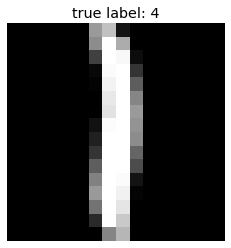

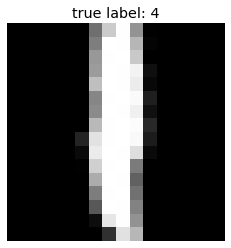

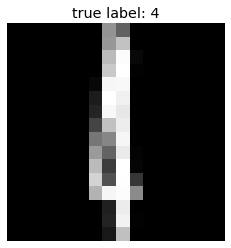

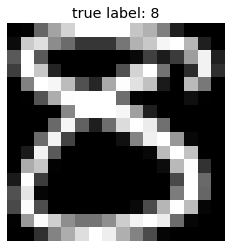

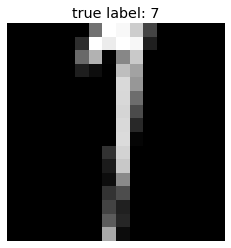

In [15]:
temp = np.argsort(-incorrectly_predicted) #we reverse sort the inccorectly predicted counter array to make it into descending order
indices_of_5_most_pixelated = temp[0,:5] #then we just take the 5 first indices of the array sorted in ascending order
counter=1
for i in indices_of_5_most_pixelated:
    counter=counter+1
    #print(i)
    plt.imshow(np.reshape(full_data[i,1:],(16,16)), cmap='gray')
    plt.grid(None)
    plt.axis('off')
    plt.title('true label: ' + str(int(full_data[i,0])))
    plt.savefig('Q1_' + str(counter)+'.png')
    plt.show()

Repeat 1 and 2 (d∗ is now c and {1, . . . , 7} is now S) above with a Gaussian kernel $K(p,q) = e^{-c || p - q||^{2}}$ c the width of the kernel is now a parameter which must be optimised during cross-validation however, you will also need to perform some initial experiments to a decide a reasonable set S of values to crossvalidate c over.


In [16]:
import scipy.spatial.distance as cd
def Gaussian_kernel_matrix(x,y,c):
    """ function to return the log of gaussian kernel gram matrix with parameter array c """
    data1 = x.copy()
    data2 = y.copy()
    data1 = data1[:,1:] #getting rid of label column
    data2 = data2[:,1:] #getting rid of label column
    #cdist allows us to compute pairwise squared euclidean distances between rows of x and rows of y
    K = ((cd.cdist(data1, data2))**2) #I will multiply by c and exponentiate during training to reduce training costs

    return K

def test_one_versus_rest(test,classes,powers, alpha,testing_kernel):
    """ testing function for one versus rest with gaussian kernel
    inputs:
        test: the ground truth labels of the testing data
        classes: the possible classes of our data 
        powers: the powers that we want to pass to polynomial kernel
        alpha: the alpha values found by the training algorithm
        testing_kernel
        
        outputs:
            
            confidence: the (NumberOfPowers by NumberOfClasses by NumberOfDataPoints) 3D-dimensional array containing 
            the confidences of each of our 10(=NumberOfClasses) OVR classifiers trained on the training data with polynomial kernel power=d (for d=1 to NumberOfPowers) tested on a 
            test set with size=NumberOfDataPoints. 
            prediction: the (NumberOfPowers by NumberOfDataPoints) array containing the predicted label which is found by taking the confidence array and taking argmax of the confidence array across 
            second dimension of the array (ie across NumberOfClasses). This finds the indices(or labels) that maximise the confidence
            accuracy: the (1 by NumberOfPowers) dimensional accuracies of our predictions. Found by checking the prediction array against the ground truth labels"""
    testing_data = test.copy()


    NumberOfClasses = classes.shape[1]
    NumberOfDataPoints = testing_data.shape[0]
    NumberOfPowers = powers.shape[1]
    confidence = np.zeros((NumberOfPowers,NumberOfClasses,NumberOfDataPoints))
    predictions = np.zeros((NumberOfPowers,NumberOfDataPoints))
    counter = np.zeros((NumberOfPowers,NumberOfDataPoints))

    for d in range(NumberOfPowers):
        currK = np.exp(-1*powers[0,d]*testing_kernel)
        for t in range(NumberOfDataPoints):
            y_t = testing_data[[t],0] #receive label


            
            confidence[d,:,[t]] = (np.matmul(alpha[d,:,:],currK[:, [t]])).T
            predictions[d,[t]] = np.argmax(confidence[d,:,[t]], axis=1)
            y_hat = predictions[d,[t]]
            
            #if correct prediction
            counter[d,[t]] = 1*((y_hat  == y_t))

        
    accuracy = 100*np.sum(counter,axis=1)/NumberOfDataPoints
    return accuracy, confidence, predictions


def train_one_versus_rest(labelsdata,classes,powers, EPOCHS,training_kernel):
    """
    function to train NumberOfClasses ovr classifiers in parallel
    INPUT
     data: training data's original labels 
     classes: labels we want to classify the data to
     powers: powers we're passing to our kernel function
     EPOCHS: is the number of times we cycle through data
     training_kernel

     OUTPUT
     alpha: the final alpha values after the training has finished
     it is (NumberOfPowers by NumberOfClasses by NumberOfDataPoints) dimensional
    """
    training_data = labelsdata.copy()
    k_class_train = OneVersusRest(training_data,classes)


    
    NumberOfClasses = classes.shape[1]
    NumberOfDataPoints = training_data.shape[0]
    NumberOfPowers = powers.shape[1]
    #initialise alpha vector
    alpha = np.zeros((NumberOfPowers,NumberOfClasses,NumberOfDataPoints))
    for epoch in range(EPOCHS):
        for d in range(NumberOfPowers):

            currK = np.exp(-1*powers[0,d]*training_kernel)#here i calculate the actual gaussian kernel values for the range of c values(widths).Doing this I don't have to store a gaussian kernel matrix for each c 


            for t in range(NumberOfDataPoints):
                y_t = k_class_train[[t],:] #receive label


                #prediction step
                y_hat = np.sign(np.matmul(alpha[d,:,:],currK[:, [t]]))
                y_hat = np.squeeze(y_hat)
                #training step
                alpha[d,:,t] = alpha[d,:,t] + y_t*((y_hat != y_t)) #update alpha only if prediction wrong

    return alpha



In [17]:

full_gaussian_kernel = Gaussian_kernel_matrix(zipcombo,zipcombo,1)

In [18]:
#this code cell takes about 2 minutes to run
#initial exploration to find c range to crossvalidate over
MAXRUNS=5

powers = np.array([[-1,-0.75, -0.5, -0.25, 0, 0.25,0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]])

full_data = zipcombo.copy()
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
NUMPOWERS = powers.shape[1]
epochs=2
rng = np.random.default_rng(seed=7) #rng for shuffling data
indicesFullData = np.arange(full_data.shape[0])


initial_exploration_training_accuracies = np.zeros((MAXRUNS, NUMPOWERS))


for runs in range(MAXRUNS):
    print(runs)
    rng.shuffle(indicesFullData, axis=0)
    splits=np.array_split(labelsdata[indicesFullData,[0]],5) #5 splits for training and testing separation
    training_data =np.array([np.hstack(splits[:4])]).T #4/5 parts or 80% as training split

    indexsplit = np.array_split(indicesFullData,5)
    indextrain = np.concatenate((indexsplit[0], indexsplit[1],indexsplit[2],indexsplit[3]))
    training_kernel = full_gaussian_kernel[indextrain,:][:,indextrain]

    
    alpha = train_one_versus_rest(training_data,classes,powers,epochs,training_kernel) #training and returning alpha
    training_acc, training_conf, train_predictions = test_one_versus_rest(training_data,classes,powers, alpha,training_kernel) #training accuracies


    initial_exploration_training_accuracies[runs,:] = training_acc  #storing exploratory accuracies


0
1
2
3
4


In [19]:
print('training accuracies for OVR with gaussian kernel with parameter c averaged over 5 runs:')

for i in range(NUMPOWERS):
    print('c=' + str(powers[0,i]) + "   %.3f" %(np.mean(initial_exploration_training_accuracies, axis=0))[i])

training accuracies for OVR with gaussian kernel with parameter c averaged over 5 runs:
c=-1.0   3.250
c=-0.75   3.186
c=-0.5   3.159
c=-0.25   3.111
c=0.0   10.507
c=0.25   99.642
c=0.5   99.653
c=0.75   99.629
c=1.0   99.624
c=1.25   99.624
c=1.5   99.624
c=1.75   99.626
c=2.0   99.621


Above we can see that the initial exploration training accuracies sharply increase between c=0 and c=1. To avoid the risk of overfitting, I will not investigate beyond c=1 as the training accuracy at c=1 is already quite high. Instead I will further investigate  values of c=(0.5)^n for n=0 to 15 to investigate what's happening between 0 and 1 for ever decreasing values of c.

In [20]:
#this cell runs for about 3 mins
#initial exploration to find c range to crossvalidate over
MAXRUNS=5

powers = (np.array([0.5**np.arange(16)]))

full_data = zipcombo.copy()
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
NUMPOWERS = powers.shape[1]
epochs=2
rng = np.random.default_rng(seed=7) #rng for shuffling data
indicesFullData = np.arange(full_data.shape[0])


initial_exploration_training_accuracies = np.zeros((MAXRUNS, NUMPOWERS))


for runs in range(MAXRUNS):
    print(runs)
    rng.shuffle(indicesFullData, axis=0)
    splits=np.array_split(labelsdata[indicesFullData,[0]],5) #5 splits for training and testing separation
    training_data =np.array([np.hstack(splits[:4])]).T #4/5 parts or 80% as training split

    indexsplit = np.array_split(indicesFullData,5)
    indextrain = np.concatenate((indexsplit[0], indexsplit[1],indexsplit[2],indexsplit[3]))
    training_kernel = full_gaussian_kernel[indextrain,:][:,indextrain]

    
    alpha = train_one_versus_rest(training_data,classes,powers,epochs,training_kernel) #training and returning alpha
    training_acc, training_conf, train_predictions = test_one_versus_rest(training_data,classes,powers, alpha,training_kernel) #training accuracies


    initial_exploration_training_accuracies[runs,:] = training_acc  #storing exploratory accuracies

0
1
2
3
4


In [21]:
print('training accuracies for OVR with gaussian kernel with parameter c averaged over 5 runs:')

for i in range(NUMPOWERS):
    print('index:'+ str(i)+', c=' + str(powers[0,i]) + "   %.3f" %(np.mean(initial_exploration_training_accuracies, axis=0))[i])

training accuracies for OVR with gaussian kernel with parameter c averaged over 5 runs:
index:0, c=1.0   99.624
index:1, c=0.5   99.653
index:2, c=0.25   99.642
index:3, c=0.125   99.696
index:4, c=0.0625   99.769
index:5, c=0.03125   99.855
index:6, c=0.015625   99.796
index:7, c=0.0078125   99.336
index:8, c=0.00390625   97.871
index:9, c=0.001953125   95.454
index:10, c=0.0009765625   92.526
index:11, c=0.00048828125   89.622
index:12, c=0.000244140625   82.646
index:13, c=0.0001220703125   85.622
index:14, c=6.103515625e-05   67.552
index:15, c=3.0517578125e-05   59.524


As we can see we first pass the 90% accuracy threshold at index 10 and from index 10 to index 5 the accuracies are increasing. Thus I will be cross validating values of c=(0.5)^n for n=5 to 10 and this will be S.

1) repeated in gaussian kernel

In [22]:
#this cell runs for about 5 minutes
S = (np.array([0.5**np.arange(5,11)]))
MAXRUNS=20


full_data = zipcombo.copy()
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
NUMPOWERS = S.shape[1]
epochs=2
rng = np.random.default_rng(seed=7) #rng for shuffling data
indicesFullData = np.arange(full_data.shape[0])


all_training_accuracies_gaussian = np.zeros((MAXRUNS, NUMPOWERS))
all_testing_accuracies_gaussian = np.zeros((MAXRUNS, NUMPOWERS))

for runs in range(MAXRUNS):
    print(runs)
    rng.shuffle(indicesFullData, axis=0)
    splits=np.array_split(labelsdata[indicesFullData,[0]],5) #5 splits for training and testing separation
    training_data =np.array([np.hstack(splits[:4])]).T #4/5 parts or 80% as training split
    testing_data = np.array([splits[4]]).T #1/5 parts or 20% as testing split
    indexsplit = np.array_split(indicesFullData,5)
    indextrain = np.concatenate((indexsplit[0], indexsplit[1],indexsplit[2],indexsplit[3]))
    indextest = indexsplit[4]


    training_kernel = full_gaussian_kernel[indextrain,:][:,indextrain]
    testing_kernel = full_gaussian_kernel[indextrain,:][:,indextest]

    alpha = train_one_versus_rest(training_data,classes,S,epochs,training_kernel) #training and returning alpha
    training_acc, training_conf, train_predictions = test_one_versus_rest(training_data,classes,S, alpha,training_kernel) #training accuracies
    testing_acc, testing_conf, test_predictions = test_one_versus_rest(testing_data,classes,S, alpha,testing_kernel) #testing accuracies

    all_training_accuracies_gaussian[runs,:] = training_acc  #storing accuracies
    all_testing_accuracies_gaussian[runs,:] = testing_acc    #storing accuracies

    if(runs==0):
        test_predictions_store_gaussian = test_predictions
        train_predictions_store_gaussian = train_predictions
    else:
        test_predictions_store_gaussian = np.dstack((test_predictions_store_gaussian,test_predictions))
        train_predictions_store_gaussian = np.dstack((train_predictions_store_gaussian,train_predictions))

test_predictions_store_gaussian = np.transpose(test_predictions_store_gaussian,(2,0,1))
train_predictions_store_gaussian = np.transpose(train_predictions_store_gaussian,(2,0,1))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [23]:
test_errors_gaussian  = 100 - all_testing_accuracies_gaussian
train_errors_gaussian  = 100 - all_training_accuracies_gaussian

print('c            training error(mean±std)            testing errors(mean±std)')
for d in range(NUMPOWERS):
    print(str(S[0,d]), end='            ')
    print(str("%.4f" % np.mean(train_errors_gaussian, axis=0)[d]) + '±' + str("%.4f" % np.std(train_errors_gaussian, axis=0)[d]), end='                     ')
    print(str("%.4f" % np.mean(test_errors_gaussian, axis=0)[d]) + '±' + str("%.4f" % np.std(test_errors_gaussian, axis=0)[d]))




c            training error(mean±std)            testing errors(mean±std)
0.03125            0.1741±0.0695                     3.3217±0.4545
0.015625            0.2373±0.1356                     2.9398±0.3665
0.0078125            0.6419±0.2343                     3.5557±0.4950
0.00390625            2.4802±0.4829                     5.0538±0.8802
0.001953125            4.5436±0.9064                     6.4228±1.0458
0.0009765625            7.9661±2.5635                     9.2200±2.8364


2) repeated in gaussian kernel

In [24]:
#this cell runs for about 16 minutes
MAXRUNS=20
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
S = (np.array([0.5**np.arange(5,11)]))
NUMPOWERS = powers.shape[1]
epochs=2

indicesFullData = np.arange(full_data.shape[0])
rng = np.random.default_rng(seed=7) #rng for shuffling data
optimal_c_gaussian = np.zeros((MAXRUNS,1))

for runs in range(MAXRUNS):
    print(runs)
    rng.shuffle(indicesFullData, axis=0)
    splits=np.array_split(labelsdata[indicesFullData,[0]],5) #5 splits for training and testing separation
    training_data =np.array([np.hstack(splits[:4])]).T #4/5 parts or 80% as training split

    
    indexsplit = np.array_split(indicesFullData,5)
    indextrain = np.concatenate((indexsplit[0], indexsplit[1],indexsplit[2],indexsplit[3]))


    #cross validation to find optimal d
    cross_splits = np.array_split(training_data,5)
    cross_splits_indices = np.array_split(indextrain,5)
    accuracies_sum=0
    for fold_number in range(5):
        training_folds = np.vstack(np.delete(cross_splits, fold_number))
        training_folds_indices = np.hstack(np.delete(cross_splits_indices, fold_number))
        training_kernel = full_gaussian_kernel[training_folds_indices,:][:,training_folds_indices]


        alpha = train_one_versus_rest(training_folds,classes,S,epochs,training_kernel) #training and returning alpha
        training_acc, training_conf, train_predictions = test_one_versus_rest(training_folds,classes,S, alpha,training_kernel) #training accuracies
        accuracies_sum = accuracies_sum + training_acc
    optimal_c_gaussian[runs,0] = np.argmax(accuracies_sum, axis=0)

0


c:\Users\riand\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [25]:
optimal_c_gaussian = optimal_c_gaussian.astype(int)
optimal_c_gaussian_test_errors = test_errors_gaussian[range(len(optimal_c_gaussian[:,0])),optimal_c_gaussian[:,0]]
for i in range(20):
    print('run:' + str(i+1) + ', optimal c:'+str(S[0,optimal_c_gaussian[i,0]]) + ', associated test error:' + str(round(optimal_c_gaussian_test_errors[i],3)))

run:1, optimal c:0.03125, associated test error:2.743
run:2, optimal c:0.03125, associated test error:3.281
run:3, optimal c:0.015625, associated test error:2.797
run:4, optimal c:0.03125, associated test error:3.55
run:5, optimal c:0.03125, associated test error:3.281
run:6, optimal c:0.03125, associated test error:3.066
run:7, optimal c:0.03125, associated test error:3.819
run:8, optimal c:0.03125, associated test error:3.712
run:9, optimal c:0.03125, associated test error:2.905
run:10, optimal c:0.03125, associated test error:3.604
run:11, optimal c:0.03125, associated test error:3.281
run:12, optimal c:0.015625, associated test error:2.259
run:13, optimal c:0.03125, associated test error:4.034
run:14, optimal c:0.03125, associated test error:2.743
run:15, optimal c:0.03125, associated test error:3.55
run:16, optimal c:0.03125, associated test error:2.69
run:17, optimal c:0.03125, associated test error:2.743
run:18, optimal c:0.03125, associated test error:4.088
run:19, optimal c:0.

In [26]:
print('mean optimal c with std: ' + str(round(np.mean(S[:,optimal_c_gaussian]),3)) + "±" +  str(round(np.std(S[:,optimal_c_gaussian]),3)))
print('mean optimal test error with std: ' + str(round(np.mean(optimal_c_gaussian_test_errors),3)) + "±" +  str(round(np.std(optimal_c_gaussian_test_errors),3)))

mean optimal c with std: 0.03±0.005
mean optimal test error with std: 3.271±0.495


6. Choose (research) an alternate method to generalise the kernel perceptron to k-classes then repeat 1
and 2

In [27]:
def OneVersusOne(label, i,j):
    """ function to transform label in one verus one form """
    return int(label==i) - int(label==j)

def filter_indices(labels,indices,i,j):
    """ function to filter an array of indices keeping only the indices that have labels i and j """
    return np.intersect1d(np.where(labelsdata==[i,j])[0], indices)

def Poly_kernel_matrix(x,y,d):
    """ function to compute gram matrix for polynomial kernel with power d=1. Using the first power we can then iteratively multiply the gram matrix with itself to build higher powers of it. """
    data1 = x.copy()
    data2 = y.copy()
    data1 = data1[:,1:] #getting rid of label column
    data2 = data2[:,1:] #getting rid of label column
    K = (data1@ np.transpose(data2))
    return K


def test_one_versus_one(all_labels,classes,powers,training_indices,testing_indices,BigAlpha,fullkernelmatrix):
    """ testing function for one versus one with polynomial kernel
    inputs:
        all_labels: the ground truth labels of the testing data
        classes: the possible classes of our data 
        powers: the powers that we want to pass to polynomial kernel
        training_indices: the indices of the data corresponding to training set. Used to extract the right rows of kernel matrix
        testing_indices: the indices of the data corresponding to testing set. Used to extract the right columns of kernel matrix
        BigAlpha: the alpha values found by the training algorithm
        fullkernelmatrixx: the gram matrix calculated for the whole dataset. by calculating it once and extracting what we need we save some time
        
        outputs:
            
            confidence: the (NumberOfPowers by NumberOfClasses by NumberOfDataPoints) 3D-dimensional array containing 
            the confidences of each of our 10(=NumberOfClasses) OVR classifiers trained on the training data with polynomial kernel power=d (for d=1 to NumberOfPowers) tested on a 
            test set with size=NumberOfDataPoints. 
            predictions: the (NumberOfPowers  by NumberOfDataPoints) array containing the predicted label which is found by taking the SUM of all the confidences of classsifiers related to digit i 
            (this gives a NumberOfPowers by NUMCLASSES by NumberOfTestPoints) and taking argmax of this sum of confidence array across the second dimension.This finds the indices(or labels) that maximise the confidence
            accuracy: the (1 by NumberOfPowers) dimensional accuracies of our predictions. Found by checking the prediction array against the ground truth labels"""
    NUMCLASSES = classes.shape[1]
    NumberOfPowers = powers.shape[1]
    counter=0 #this counter will keep track of which of the 45 classifiers we're currently on

    index_list_testing = testing_indices
    NumberOfTestPoints = index_list_testing.shape[0]
    all_confidences = np.zeros((NumberOfPowers,NUMCLASSES,NUMCLASSES, NumberOfTestPoints))
    
    #for loops to cycle through possible 2 digit combinations
    for i in range(NUMCLASSES):
        for j in range(i+1,NUMCLASSES):
            if(i==j): #not interested in training OVA for i=j as we'd be training on one class whereas OVO requires two
                continue
            index_list_training = filter_indices(all_labels,training_indices,i,j) #keep only the data that has the labels we're interested in

            testing_ker = fullkernelmatrix[index_list_training,:][:,index_list_testing] #extract corresponding kernel values

            curr_ker=1
            confidence = np.empty((NumberOfPowers,NumberOfTestPoints))
            for d in range(NumberOfPowers):
                curr_ker = curr_ker*testing_ker #iteratively multiply the kernel matrix with itself to go through the range of powers
                confidence = ((BigAlpha[counter])[d,:])@curr_ker #remember counter keeeps track of which classifier we're on
                
                #since training to distinguish digits i and j is the same as distinguishing labels j and i (just with the +1, -1 OVO labels reversed). We can use this fact to compute the confidence of
                #classfier h(j,i) as the negative of the confidence of classifier h(i,j)
                all_confidences[d,i,j,:] = confidence
                all_confidences[d,j,i,:] = -1*confidence
            counter=counter+1

    #we sum all the confidences of classifiers that have been trained to distinguish digit i and then find the argmax of all these summed confidences
    predictions = np.argmax(np.sum(all_confidences, axis=2), axis=1)
    accuracies = 100*np.mean(predictions==np.squeeze(all_labels[testing_indices]),axis=1)
    return predictions,accuracies

def train_one_versus_one(all_labels,classes,powers, EPOCHS,training_indices,fullkernelmatrix):
    """ training function for one versus one with polynomial kernel
    inputs:
        all_labels: the ground truth labels of the training data
        classes: the possible classes of our data 
        powers: the powers that we want to pass to polynomial kernel
        training_indices: the indices of the data corresponding to training set. Used to extract the right rows of kernel matrix
        fullkernelmatrixx: the gram matrix calculated for the whole dataset. by calculating it once and extracting what we need we save some time
        
        outputs:
            
            BigAlpha: the alpha values found by the training algorithm. It contains 45 individual (NumberOfPowers by NumberOfDataPoints) arrays, one for each classifier."""

    NUMCLASSES = classes.shape[1]
    NumberOfPowers = powers.shape[1]
    BigAlpha = []

    for i in range(NUMCLASSES):
        for j in range(i+1,NUMCLASSES):
            if(i==j): #not interested in training OVA for i=j as we'd be training on one class whereas OVA requires two
                continue
            index_list = filter_indices(all_labels,training_indices,i,j)
            training_ker = fullkernelmatrix[index_list,:][:,index_list]
            NumberOfDataPoints = index_list.shape[0]
            alpha = np.zeros((NumberOfPowers, NumberOfDataPoints))
            for epochs in range(EPOCHS):
                curr_ker=1
                for d in range(NumberOfPowers):
                    curr_ker = curr_ker*training_ker
                    for t in range(NumberOfDataPoints):
                        y_t = OneVersusOne(all_labels[index_list[t],:],i,j) #receive label and transform to OVO form
                        #prediction step
                        y_hat = np.sign(alpha[d,:]@curr_ker[:, [t]])
                        #training step
                        if(y_t!=y_hat):
                            alpha[d,t] = alpha[d,t] + y_t #update alpha only if prediction wrong)
            BigAlpha.append(alpha)     
    return BigAlpha

1) repeated with alternative method (Basic Results: Perform 20 runs for d = 1, . . . , 7 each run should randomly split zipcombo into 80%
train and 20% test. Report the mean test and train error rates as well as well as standard deviations.
Thus your data table, here, will be 2 × 7 with each “cell” containing a mean±std.).

In [28]:
full_ker_poly  = Poly_kernel_matrix(zipcombo,zipcombo,1)

In [29]:
#this cell runs for about 13 minutes
MAXRUNS=20
powers=np.array([[1,2,3,4,5,6,7]])
labelsdata = full_data[:,[0]]
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
NUMPOWERS = powers.shape[1]
epochs=2
rng = np.random.default_rng(seed=7) #rng for shuffling data
indicesFullData = np.arange(full_data.shape[0])
all_training_accuracies_ovo = np.zeros((MAXRUNS, NUMPOWERS))
all_testing_accuracies_ovo = np.zeros((MAXRUNS, NUMPOWERS))

for runs in range(MAXRUNS):
    print(runs)
    rng.shuffle(indicesFullData, axis=0)

    indexsplit = np.array_split(indicesFullData,5)
    indextrain = np.concatenate((indexsplit[0], indexsplit[1],indexsplit[2],indexsplit[3]))
    indextest = indexsplit[4]

    BigAlpha=train_one_versus_one(labelsdata,classes,powers,epochs,indextrain,full_ker_poly) #training and returning alphas
    test_predictions,test_accuracies = test_one_versus_one(labelsdata,classes,powers,indextrain,indextest,BigAlpha,full_ker_poly)
    train_predictions,train_accuracies = test_one_versus_one(labelsdata,classes,powers,indextrain,indextrain,BigAlpha,full_ker_poly)
    all_training_accuracies_ovo[runs,:] = train_accuracies  #storing accuracies
    all_testing_accuracies_ovo[runs,:] = test_accuracies    #storing accuracies

    if(runs==0):
        test_predictions_store_ovo = test_predictions
        train_predictions_store_ovo = train_predictions
    else:
        test_predictions_store_ovo = np.dstack((test_predictions_store_ovo,test_predictions))
        train_predictions_store_ovo= np.dstack((train_predictions_store_ovo,train_predictions))

test_predictions_store_ovo = np.transpose(test_predictions_store_ovo,(2,0,1))
train_predictions_store_ovo = np.transpose(train_predictions_store_ovo,(2,0,1))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [30]:
test_errors_ovo  = 100 - all_testing_accuracies_ovo
train_errors_ovo  = 100 - all_training_accuracies_ovo
print('>>>ONE VERSUS ONE multiclass prediction<<<')
print('training errors(mean±std):')
for d in range(NUMPOWERS):
    print(str(round(np.mean(train_errors_ovo, axis=0)[d],2)) + "±" +  str(round(np.std(train_errors_ovo, axis=0)[d],2)),  end='       ')
print('\ntesting errors(mean±std):')
for d in range(NUMPOWERS):
    print(str(round(np.mean(test_errors_ovo, axis=0)[d],2)) + "±" +  str(round(np.std(test_errors_ovo, axis=0)[d],2)),  end='     ')

>>>ONE VERSUS ONE multiclass prediction<<<
training errors(mean±std):
14.64±1.62       4.56±0.66       2.33±0.25       1.39±0.16       1.02±0.14       0.81±0.13       0.67±0.12       
testing errors(mean±std):
15.28±1.94     6.58±0.79     4.8±0.59     4.13±0.48     3.82±0.46     3.67±0.46     3.49±0.45     

2) repeated with alternative method( Cross-validation: Perform 20 runs : when using the 80% training data split from within to perform
5-fold cross-validation to select the “best” parameter d
∗
then retrain on full 80% training set using
d
∗ and then record the test errors on the remaining 20%. Thus you will find 20 d
∗ and 20 test errors.
Your final result will consist of a mean test error±std and a mean d
∗ with std.).

In [31]:
#this cell runs for about 44 minutes
MAXRUNS=20
classes = np.array([[0,1,2,3,4,5,6,7,8,9]])
powers=np.array([[1,2,3,4,5,6,7]])
NUMPOWERS = powers.shape[1]
epochs=2
indicesFullData = np.arange(full_data.shape[0])
rng = np.random.default_rng(seed=7) #rng for shuffling data
optimal_d_ovo = np.zeros((MAXRUNS,1))

for runs in range(MAXRUNS):
    print(runs)
    rng.shuffle(indicesFullData, axis=0)

    
    indexsplit = np.array_split(indicesFullData,5)
    indextrain = np.concatenate((indexsplit[0], indexsplit[1],indexsplit[2],indexsplit[3]))


    #cross validation to find optimal d

    cross_splits_indices = np.array_split(indextrain,5)
    accuracies_sum=0
    for fold_number in range(5):
        training_folds_indices = np.hstack(np.delete(cross_splits_indices, fold_number))


        BigAlpha=train_one_versus_one(labelsdata,classes,powers,epochs,training_folds_indices,full_ker_poly) #training and returning alphas
        train_predictions,train_accuracies = test_one_versus_one(labelsdata,classes,powers,training_folds_indices,training_folds_indices,BigAlpha,full_ker_poly)
        accuracies_sum = accuracies_sum + train_accuracies
    optimal_d_ovo[runs,0] = np.argmax(accuracies_sum, axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [35]:
optimal_d_ovo = optimal_d_ovo.astype(int)
#print(optimal_d+1) #20 optimal d value indices. Indexing starts at 0 so shifted by +1 (powers run from 1 to 7)
optimal_d_ovo_test_errors = test_errors[range(len(optimal_d_ovo[:,0])),optimal_d_ovo[:,0]]
for i in range(20):
    print('run:' + str(i+1) + ', optimal d:'+str(optimal_d_ovo[i,0]+1) + ', associated test error:' + str(round(optimal_d_ovo_test_errors[i],3)))

run:1, optimal d:7, associated test error:3.228
run:2, optimal d:7, associated test error:3.55
run:3, optimal d:7, associated test error:2.797
run:4, optimal d:6, associated test error:3.335
run:5, optimal d:7, associated test error:3.228
run:6, optimal d:7, associated test error:2.905
run:7, optimal d:7, associated test error:3.012
run:8, optimal d:7, associated test error:3.335
run:9, optimal d:7, associated test error:2.636
run:10, optimal d:7, associated test error:4.196
run:11, optimal d:7, associated test error:3.335
run:12, optimal d:6, associated test error:2.797
run:13, optimal d:7, associated test error:3.389
run:14, optimal d:7, associated test error:2.797
run:15, optimal d:7, associated test error:3.497
run:16, optimal d:7, associated test error:2.69
run:17, optimal d:7, associated test error:2.743
run:18, optimal d:7, associated test error:3.443
run:19, optimal d:7, associated test error:3.712
run:20, optimal d:7, associated test error:3.228


In [32]:
print('mean optimal d with std: ' + str(round(np.mean(optimal_d_ovo+1),3)) + "±" +  str(round(np.std(optimal_d_ovo+1),3)))
print('mean optimal test error with std: ' + str(round(np.mean(optimal_d_ovo_test_errors),3)) + "±" +  str(round(np.std(optimal_d_ovo_test_errors),3)))

mean optimal d with std: 6.9±0.3
mean optimal test error with std: 3.193±0.388
